In [1]:
import sys

# setting path
sys.path.append('..')

In [54]:
# outside package
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
import pickle

# Read Data

In [3]:
heroes_data = pd.read_csv("../data/processed_data/heroes_data.csv", index_col=0)
heroes_data.head()

,id,name,win_rate,against_hero_1,against_hero_2,against_hero_3,against_hero_4,against_hero_5,against_hero_6,against_hero_7,...,against_hero_119,against_hero_120,against_hero_121,against_hero_123,against_hero_126,against_hero_128,against_hero_129,against_hero_135,against_hero_136,against_hero_137
0,1,Anti-Mage,0.489100,NaN,0.566667,0.464789,0.447368,0.441860,0.608696,0.588235,...,0.545455,0.500000,0.535433,0.381579,0.477273,0.460526,0.413793,0.428571,0.520000,0.521739
1,2,Axe,0.485514,0.433333,NaN,0.474576,0.576923,0.471264,0.507937,0.666667,...,0.473684,0.482143,0.474227,0.508475,0.486486,0.490196,0.544828,0.419355,0.471429,0.392857
2,3,Bane,0.552398,0.535211,0.525424,NaN,0.605042,0.576087,0.495413,0.562500,...,0.516129,0.530928,0.592018,0.617925,0.616822,0.595745,0.583984,0.547945,0.490066,0.589744
3,4,Bloodseeker,0.496582,0.552632,0.423077,0.394958,NaN,0.589147,0.480769,0.490909,...,0.480000,0.515513,0.620321,0.537313,0.567164,0.506550,0.517647,0.517413,0.483871,0.387755
4,5,Crystal Maiden,0.496833,0.558140,0.528736,0.423913,0.410853,NaN,0.491124,0.461538,...,0.519481,0.507519,0.550296,0.516807,0.400000,0.482085,0.538462,0.492593,0.490141,0.514851


In [4]:
heroes_stats = pd.read_csv("../data/processed_data/heroes_stats.csv", index_col=0)
heroes_stats.head()

,id,localized_name,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_mr,base_attack_min,base_attack_max,...,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support,agi,int,Melee
0,1,Anti-Mage,200,0.25,75,0.0,0.0,25,29,33,...,0,1,0,0,1,0,0,1,0,1
1,2,Axe,200,2.50,75,0.0,-1.0,25,27,31,...,1,0,1,1,0,0,0,0,0,1
2,3,Bane,200,0.25,75,0.0,1.0,25,33,39,...,1,0,0,0,1,0,1,0,1,0
3,4,Bloodseeker,200,0.25,75,0.0,2.0,25,35,41,...,0,0,1,1,1,0,0,1,0,1
4,5,Crystal Maiden,200,0.25,75,1.0,-1.0,25,28,34,...,0,0,0,1,1,0,1,0,1,0


In [5]:
data = pd.read_csv("../data/processed_data/data.json", index_col=0)
data.head()

,match_id,radiant_win,region,patch,first_pick_team,selection_0,selection_1,selection_2,selection_3,selection_4,...,selection_14,selection_15,selection_16,selection_17,selection_18,selection_19,selection_20,selection_21,selection_22,selection_23
0,6974098635,False,3,51,0,100,97,86,19,103,...,69,71,114,89,13,52,76,106,129,39
1,6530275776,False,3,50,0,90,16,120,43,85,...,13,107,121,72,64,25,91,47,15,61
2,6164211366,False,17,49,1,51,88,129,25,103,...,75,47,106,54,77,10,28,15,95,98
3,6423063194,True,3,49,0,39,71,23,63,3,...,68,86,94,1,88,21,79,13,114,100
4,6445858823,True,5,49,1,129,23,71,91,63,...,114,64,39,106,121,44,48,95,25,9


In [6]:
merged_data = pd.read_csv("../data/processed_data/merged_data.csv", index_col=0)
merged_data.head()

,match_id,radiant_win,region,patch,first_pick_team,selection_0_id,selection_0_base_health,selection_0_base_health_regen,selection_0_base_mana,selection_0_base_mana_regen,...,selection_23_Durable,selection_23_Escape,selection_23_Initiator,selection_23_Jungler,selection_23_Nuker,selection_23_Pusher,selection_23_Support,selection_23_agi,selection_23_int,selection_23_Melee
0,6974098635,False,3,51,0,100,200,1.00,75,0.5,...,0,1,0,0,1,0,0,0,1,0
1,6992915881,True,3,51,1,14,200,2.00,75,0.0,...,0,1,0,0,1,0,0,0,1,0
2,6085918133,True,10,48,1,47,200,0.25,75,0.0,...,0,1,0,0,1,0,0,0,1,0
3,6619687384,False,13,50,1,92,200,0.25,75,0.0,...,0,1,0,0,1,0,0,0,1,0
4,6092247026,True,5,48,1,47,200,0.25,75,0.0,...,0,1,0,0,1,0,0,0,1,0


# Prepare Data For Training

In [7]:
X = merged_data.drop(["match_id", "radiant_win"], axis=1)
y = merged_data["radiant_win"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

In [9]:
y_train.mean()

0.49858133103473046

In [10]:
y_test.mean()

0.5033759517310731

# Neural Network

In [11]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Convert Data to Tensor

In [12]:
training_data = TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values))
test_data = TensorDataset(torch.Tensor(X_test.values), torch.Tensor(y_test.values))

Create Data Loader

In [13]:
training_dataloader = DataLoader(training_data, batch_size=10, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True, num_workers=0)

In [14]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C]: torch.Size([10, 819])
Shape of y: torch.Size([10]) torch.float32


In [15]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(819, 2000),
            nn.ReLU(),
            nn.Linear(2000, 512),
            nn.ReLU(),
            nn.Linear(512, 200),
            nn.ReLU(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=819, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [16]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X).flatten()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [18]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    # optimize calculation time
    with torch.no_grad():
        for X, y in dataloader:
            y = y
            X, y = X.to(device), y.to(device)
            pred = model(X).flatten()
            test_loss += loss_fn(pred, y).item()
            correct += (pred == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [19]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(training_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.595490  [    0/27843]
loss: 60.000000  [ 4000/27843]
loss: 40.000000  [ 8000/27843]
loss: 60.000000  [12000/27843]
loss: 30.000000  [16000/27843]
loss: 30.000000  [20000/27843]
loss: 40.000000  [24000/27843]
Test Error: 
 Accuracy: 49.7%, Avg loss: 50.401722 

Epoch 2
-------------------------------
loss: 60.000000  [    0/27843]
loss: 70.000000  [ 4000/27843]
loss: 50.000000  [ 8000/27843]
loss: 70.000000  [12000/27843]
loss: 20.000000  [16000/27843]
loss: 20.000000  [20000/27843]
loss: 20.000000  [24000/27843]
Test Error: 
 Accuracy: 49.7%, Avg loss: 50.272597 

Epoch 3
-------------------------------
loss: 50.000000  [    0/27843]
loss: 20.000000  [ 4000/27843]
loss: 60.000000  [ 8000/27843]
loss: 70.000000  [12000/27843]
loss: 60.000000  [16000/27843]
loss: 50.000000  [20000/27843]
loss: 40.000000  [24000/27843]
Test Error: 
 Accuracy: 49.7%, Avg loss: 50.272597 

Epoch 4
-------------------------------
loss: 50.000000  [    0/27843]


## Save Model

In [20]:
torch.save(model.state_dict(), "../models/draft_evaluation_model.pth")

In [19]:
model.load_state_dict(torch.load('../models/draft_evaluation_model.pth'))

<All keys matched successfully>

In [20]:
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=819, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Predict One Line of Data


In [21]:
model(torch.atleast_2d(torch.Tensor(merged_data.iloc[3].drop(["match_id", "radiant_win"])).to(device)))

tensor([[0.]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [22]:
test(test_dataloader, model, loss_fn)


Test Error: 
 Accuracy: 49.7%, Avg loss: 50.401722 



In [23]:
y_test.mean()

0.5033759517310731

# Decision Trees


In [28]:
dt = DecisionTreeClassifier()

In [29]:
dt.fit(X_train, y_train)


DecisionTreeClassifier()

In [57]:
with open('../models/decision_tree.sav', "wb") as f:
    pickle.dump(dt, f)

In [24]:
with open('../models/decision_tree.sav', "rb") as f:
    dt = pickle.load(f)

In [25]:
dt.score(X_test, y_test) - y_test.mean()

0.002154862807068003

# Random Forest

In [31]:
rf = GridSearchCV(RandomForestClassifier(), param_grid={
    "n_estimators": [50, 100],
    "max_depth": [1, 2, 3, 4],
    "criterion": ["entropy"],
    "min_samples_split": [10],
    "n_jobs": [-1]
}, cv=5, verbose=2, n_jobs=-1)


In [32]:
rf.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [1, 2, 3, 4],
                         'min_samples_split': [10], 'n_estimators': [50, 100],
                         'n_jobs': [-1]},
             verbose=2)

In [61]:
with open('../models/random_forest.sav', "wb") as f:
    pickle.dump(rf, f)

In [26]:
with open('../models/random_forest.sav', "rb") as f:
    rf = pickle.load(f)

In [27]:
rf.best_score_ - (1 - y_train.mean())

0.012534514761146975

In [28]:
rf.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_split': 10,
 'n_estimators': 100,
 'n_jobs': -1}

In [29]:
rf.score(X_test, y_test)

0.5175980462577215

In [30]:
rf.score(X_test, y_test) - y_test.mean()

0.014222094526648466

In [31]:
pd.DataFrame(rf.best_estimator_.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False).head()


,0
patch,0.019914
selection_1_base_attack_max,0.010828
selection_14_agi_gain,0.008251
selection_0_overall_win_rate,0.008146
selection_1_attack_range,0.007891


# XGBoost


In [40]:
xgb = GridSearchCV(XGBClassifier(), param_grid={
    "booster": ["gbtree"],
    "objective": ["binary:logistic"],
    'max_depth': [1, 2, 3, 4],
    'n_estimators': [100],
    'learning_rate': [1]
}, cv=5, verbose=2, n_jobs=-1)

In [41]:
xgb.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'learning_rate': [1],
                         'max_depth': [1, 2, 3, 4], 'n_estimators': [100],
                         'objective': ['binary:logistic']},
             verbose=2)

In [67]:
with open('../models/xgboost.sav', "wb") as f:
    pickle.dump(xgb, f)

In [32]:
with open('../models/xgboost.sav', "rb") as f:
    xgb = pickle.load(f)

In [33]:
xgb.best_params_

{'booster': 'gbtree',
 'learning_rate': 1,
 'max_depth': 1,
 'n_estimators': 100,
 'objective': 'binary:logistic'}

In [34]:
xgb.score(X_test, y_test) - y_test.mean()

0.004884355696020748

# Data Analysis


In [35]:
picked_heroes = data.drop(
    ["match_id", "region", "patch"]
    + ["selection_{}".format(i) for i in [0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 18, 19, 20, 21]],
    axis=1
)
picked_heroes.head()

,radiant_win,first_pick_team,selection_4,selection_5,selection_6,selection_7,selection_14,selection_15,selection_16,selection_17,selection_22,selection_23
0,False,0,103,64,112,105,69,71,114,89,129,39
1,False,0,85,129,101,12,13,107,121,72,15,61
2,False,1,103,114,87,110,75,47,106,54,95,98
3,True,0,3,129,25,98,68,86,94,1,114,100
4,True,1,63,87,38,60,114,64,39,106,25,9


In [36]:
team_0_pick_first = picked_heroes.query("first_pick_team == 0")
team_0_pick_first.head()

,radiant_win,first_pick_team,selection_4,selection_5,selection_6,selection_7,selection_14,selection_15,selection_16,selection_17,selection_22,selection_23
0,False,0,103,64,112,105,69,71,114,89,129,39
1,False,0,85,129,101,12,13,107,121,72,15,61
3,True,0,3,129,25,98,68,86,94,1,114,100
5,False,0,91,100,25,99,129,29,26,70,46,123
6,False,0,22,19,126,38,99,8,5,37,33,104


In [37]:
team_1_pick_first = picked_heroes.query("first_pick_team == 1")
team_1_pick_first.head()

,radiant_win,first_pick_team,selection_4,selection_5,selection_6,selection_7,selection_14,selection_15,selection_16,selection_17,selection_22,selection_23
2,False,1,103,114,87,110,75,47,106,54,95,98
4,True,1,63,87,38,60,114,64,39,106,25,9
9,True,1,3,102,76,30,119,2,46,15,11,106
13,False,1,92,23,9,14,128,102,8,53,13,61
14,True,1,20,121,25,19,120,4,112,107,74,113


In [38]:
team_drafts = []
for index, row in team_0_pick_first.iterrows():
    temp = dict()
    temp["radiant_lineup"] = [row["selection_{}".format(i)] for i in [4, 7, 15, 16, 22]]
    temp["dire_lineup"] = [row["selection_{}".format(i)] for i in [5, 6, 14, 17, 23]]
    temp["radiant_win"] = row["radiant_win"]
    team_drafts.append(temp)
for index, row in team_1_pick_first.iterrows():
    temp = dict()
    temp["dire_lineup"] = [row["selection_{}".format(i)] for i in [4, 7, 15, 16, 22]]
    temp["radiant_lineup"] = [row["selection_{}".format(i)] for i in [5, 6, 14, 17, 23]]
    temp["radiant_win"] = row["radiant_win"]
    team_drafts.append(temp)

In [39]:
team_drafts = pd.DataFrame(team_drafts)
team_drafts.head()

,radiant_lineup,dire_lineup,radiant_win
0,"[103, 105, 71, 114, 129]","[64, 112, 69, 89, 39]",False
1,"[85, 12, 107, 121, 15]","[129, 101, 13, 72, 61]",False
2,"[3, 98, 86, 94, 114]","[129, 25, 68, 1, 100]",True
3,"[91, 99, 29, 26, 46]","[100, 25, 129, 70, 123]",False
4,"[22, 38, 8, 5, 33]","[19, 126, 99, 37, 104]",False


## It is usually considered that Anti-Mage (Hero ID 1) counters Medusa (Hero ID 94). We will explore if our data support this claim.

In [40]:
condition = team_drafts[["radiant_lineup", "dire_lineup"]].apply(
    lambda x: 1 in x["radiant_lineup"] and 94 in x["dire_lineup"], axis=1) | \
            team_drafts[["radiant_lineup", "dire_lineup"]].apply(
                lambda x: 94 in x["radiant_lineup"] and 1 in x["dire_lineup"], axis=1)

In [41]:
filtered_data = team_drafts[condition]
filtered_data.head()

,radiant_lineup,dire_lineup,radiant_win
2,"[3, 98, 86, 94, 114]","[129, 25, 68, 1, 100]",True
182,"[91, 94, 79, 21, 77]","[68, 129, 88, 1, 106]",False
475,"[20, 43, 123, 94, 38]","[49, 27, 64, 1, 39]",False
522,"[16, 91, 43, 72, 1]","[121, 120, 84, 94, 114]",True
676,"[120, 47, 57, 94, 59]","[3, 46, 100, 1, 35]",False


In [42]:
am_wins = 0
for index, row in filtered_data.iterrows():
    if row["radiant_win"]:
        if 1 in row["radiant_lineup"]:
            am_wins += 1
    else:
        if 1 in row["dire_lineup"]:
            am_wins += 1
am_wins / len(filtered_data)

0.5922330097087378

In [43]:
overall_am_wins = 0
total_matches_with_am = 0
for index, row in team_drafts.iterrows():
    if row["radiant_win"]:
        if 1 in row["radiant_lineup"]:
            overall_am_wins += 1
            total_matches_with_am += 1
        elif 1 in row["dire_lineup"]:
            total_matches_with_am += 1
    else:
        if 1 in row["dire_lineup"]:
            overall_am_wins += 1
            total_matches_with_am += 1
        elif 1 in row["radiant_lineup"]:
            total_matches_with_am += 1
overall_am_wins / total_matches_with_am


0.4964493221433183

## We will now explore if our model captures the Anti-Mage vs Medusa counter relationship.

In [44]:
filtered_merged_data = merged_data.loc[filtered_data.index]
filtered_merged_data.head()

,match_id,radiant_win,region,patch,first_pick_team,selection_0_id,selection_0_base_health,selection_0_base_health_regen,selection_0_base_mana,selection_0_base_mana_regen,...,selection_23_Durable,selection_23_Escape,selection_23_Initiator,selection_23_Jungler,selection_23_Nuker,selection_23_Pusher,selection_23_Support,selection_23_agi,selection_23_int,selection_23_Melee
2,6085918133,True,10,48,1,47,200,0.25,75,0.00,...,0,1,0,0,1,0,0,0,1,0
182,6844621359,True,3,51,0,85,200,0.25,75,0.25,...,0,1,0,0,1,0,0,0,1,0
475,6507696068,False,8,50,0,16,200,0.25,75,0.00,...,0,1,0,0,1,0,0,0,1,0
522,6025363045,True,15,48,1,58,200,0.25,75,0.00,...,0,1,0,0,1,0,0,0,1,0
676,6680625178,True,3,50,1,135,200,0.25,75,0.00,...,0,1,0,0,1,0,0,0,1,0


In [45]:
filtered_X = filtered_merged_data.drop(["radiant_win", "match_id"], axis=1)
filtered_y = filtered_merged_data["radiant_win"]

In [46]:
rf.score(filtered_X, filtered_y)


0.5825242718446602

In [48]:
confusion_matrix(filtered_y, rf.predict(filtered_X))

array([[71, 30],
       [56, 49]], dtype=int64)

In [51]:
confusion_matrix(filtered_y, rf.predict(filtered_X), normalize="all")

array([[0.34466019, 0.14563107],
       [0.27184466, 0.23786408]])

In [56]:
precision_score(filtered_y, rf.predict(filtered_X))

0.620253164556962

In [57]:
recall_score(filtered_y, rf.predict(filtered_X))

0.4666666666666667

In [58]:
f1_score(filtered_y, rf.predict(filtered_X))

0.532608695652174

In [59]:
roc_auc_score(filtered_y, rf.predict(filtered_X))

0.5848184818481847

## Testing tree's confidence vs accuracy.


In [106]:
def get_proba(X, classifiers):
    proba = None
    for classifier in classifiers:
        if proba is None:
            proba = classifier.predict(X)
        else:
            proba += classifier.predict(X)
    return proba / len(classifiers)

In [107]:
rf_proba = get_proba(X_test.to_numpy(), rf.best_estimator_.estimators_)
rf_proba[:5]

array([0.43, 0.56, 0.47, 0.41, 0.46])

<AxesSubplot: xlabel='bin'>

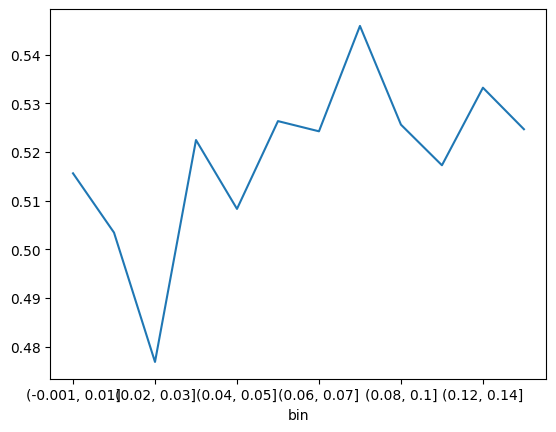

In [181]:
X_test_copy = X_test.copy()
X_test_copy["proba"] = rf_proba
X_test_copy["prediction"] = rf.predict(X_test)
X_test_copy["accurate_prediction"] = X_test_copy["prediction"] == y_test
X_test_copy["confidence"] = abs(X_test_copy["proba"] - 0.5)
X_test_copy["bin"] = pd.qcut(X_test_copy["confidence"], 12)
X_test_copy.groupby("bin").mean()["accurate_prediction"].plot()

<AxesSubplot: xlabel='bin'>

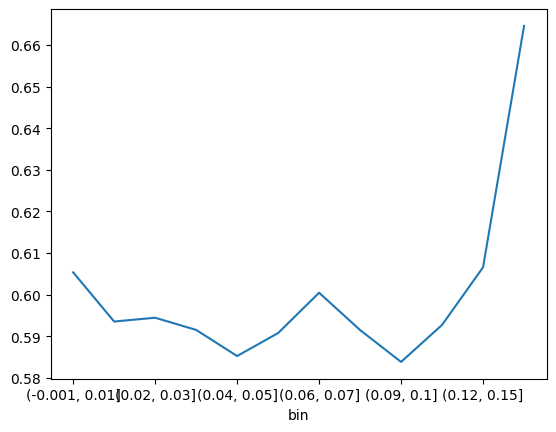

In [194]:
merged_data_copy = merged_data.copy()
merged_data_copy["proba"] = get_proba(merged_data_copy.drop(["radiant_win", "match_id"], axis=1).to_numpy(), rf.best_estimator_.estimators_)
merged_data_copy["prediction"] = rf.predict(merged_data_copy.drop(["radiant_win", "match_id", "proba"], axis=1))
merged_data_copy["accurate_prediction"] = merged_data_copy["prediction"] == merged_data_copy["radiant_win"]
merged_data_copy["confidence"] = abs(merged_data_copy["proba"] - 0.5)
merged_data_copy["bin"] = pd.qcut(merged_data_copy["confidence"], 12)
merged_data_copy.groupby("bin").mean()["accurate_prediction"].plot()
